In [10]:
import torch
import gym
import sys
sys.path.append("../environments") 
import matplotlib
import matplotlib.pyplot as plt
from star_problem import *

In [11]:
def behavior(env):
    """ Calculates action taken by Baird's counterexample behavioral policy. """
    if float(torch.rand(1)) < (1 / env.observation_space.n):
        return 1
    else:
        return 0

In [12]:
env = gym.make('StarProblem-v0')
env.reset()

states = []
for i in range(10_000):
    action = behavior(env)
    state, reward, done, info = env.step(action)
    states += [state]

[2, 0, 0, 4, 0, 0, 5, 1, 2, 0, 0, 1, 4, 2, 3, 3, 5, 3, 0, 2, 3, 3, 2, 2, 4, 5, 2, 2, 1, 4, 4, 1, 5, 5, 4, 2, 5, 1, 1, 5, 4, 3, 5, 1, 5, 0, 3, 4, 2, 0, 1, 4, 4, 1, 3, 1, 5, 5, 0, 4, 4, 3, 1, 5, 4, 1, 4, 1, 3, 4, 2, 4, 1, 4, 5, 4, 5, 5, 0, 4, 1, 1, 0, 4, 5, 5, 2, 1, 5, 4, 0, 0, 5, 4, 2, 1, 3, 4, 4, 5, 2, 3, 4, 3, 0, 3, 1, 2, 2, 4, 2, 5, 0, 0, 5, 0, 4, 4, 5, 1, 5, 1, 4, 0, 1, 2, 3, 1, 2, 0, 4, 1, 0, 1, 5, 2, 1, 0, 2, 2, 1, 5, 1, 3, 3, 1, 1, 4, 4, 3, 3, 4, 2, 2, 4, 0, 3, 2, 1, 2, 2, 3, 3, 3, 3, 3, 2, 1, 3, 4, 0, 5, 1, 4, 2, 2, 4, 5, 3, 0, 0, 5, 3, 5, 1, 3, 2, 2, 5, 3, 2, 0, 1, 3, 0, 3, 0, 4, 2, 2, 1, 0, 5, 3, 5, 1, 2, 3, 2, 5, 4, 5, 1, 3, 3, 1, 5, 2, 3, 2, 1, 3, 0, 4, 2, 3, 2, 0, 1, 4, 5, 4, 1, 4, 4, 2, 2, 2, 2, 0, 0, 3, 1, 4, 4, 0, 2, 1, 0, 1, 3, 4, 5, 0, 1, 0, 4, 2, 0, 3, 2, 1, 5, 3, 3, 3, 5, 5, 0, 4, 1, 0, 1, 3, 4, 3, 5, 5, 3, 3, 2, 1, 4, 3, 4, 5, 0, 0, 0, 2, 4, 2, 4, 2, 2, 2, 0, 3, 5, 1, 0, 3, 3, 4, 2, 2, 2, 5, 1, 2, 4, 4, 2, 1, 3, 3, 0, 2, 5, 2, 5, 3, 5, 1, 1, 0, 0, 5, 4, 3, 2, 0, 0, 

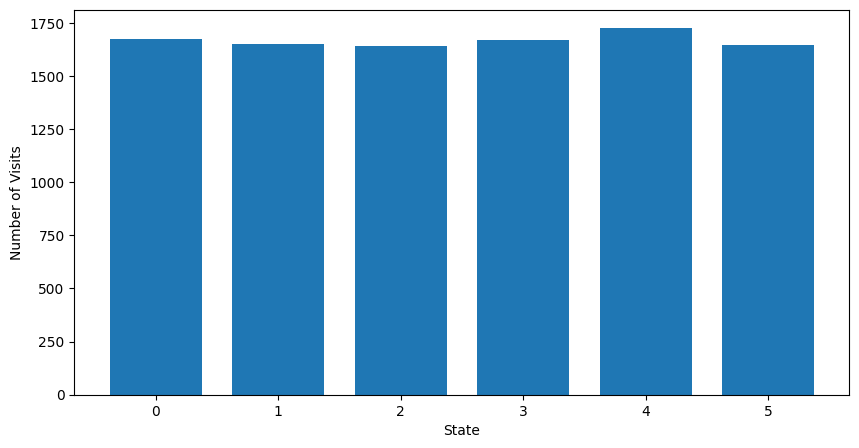

In [13]:
matplotlib.rcParams['figure.figsize'] = [10, 5]

bins = range(0, env.observation_space.n + 1)
plt.hist(states, bins=bins, rwidth=0.75, align='left')
print(states)
plt.xlabel("State")
plt.ylabel("Number of Visits")

plt.show()

In [14]:


class StarProblemSemiGradientQL:
    def __init__(self, gamma=0.99, alpha=0.05):
        self.gamma = gamma
        self.alpha = alpha
        self.n_states = 6
        self.n_actions = 2
        
        self.features = torch.eye(self.n_states, dtype=torch.float, requires_grad=False)
        self.features = torch.tensor(
        [
            [1, 1, 0, 0, 0, 0, 0],  # Upper state 1
            [1, 0, 1, 0, 0, 0, 0],  # Upper state 2
            [1, 0, 0, 1, 0, 0, 0],  # Upper state 3
            [1, 0, 0, 0, 1, 0, 0],  # Upper state 4
            [1, 0, 0, 0, 0, 1, 0],  # Upper state 5
            [1, 0, 0, 0, 0, 0, 1],  # Upper state 6
        ],
        dtype=torch.float,
        requires_grad=False
    )
        # Initialize weights (6 features x 2 actions)
        self.weights = torch.randn((7, self.n_actions), requires_grad=True)
        
    def q_value(self, state, action):
        """Compute Q(s, a) = features[state] @ weights[:, action]."""
        return self.features[state] @ self.weights[:, action]
    
    def update(self, state, action, reward, next_state):
        """Semi-gradient Q-learning update."""
        q_val = self.q_value(state, action)
        max_q_next = torch.max(self.q_value(next_state, 0), self.q_value(next_state, 1))
        target = reward + self.gamma * max_q_next
        
        # Compute gradient and update weights
        q_val.backward()
        with torch.no_grad():
            self.weights += self.alpha * (target - q_val) * self.weights.grad
            self.weights.grad.zero_()
    
    def train(self, env, n_steps=1000):
        history = []
        state = env.reset()
        
        for step in range(n_steps):
            action = env.action_space.sample()  # Random behavior policy
            next_state, reward, done, _ = env.step(action)
            self.update(state, action, reward, next_state)
            state = next_state
            
            # Track weight for action 0 (optional)
            history.append(self.weights[:, 0].detach().numpy().copy())
        
        return history

# Example usage:
env = gym.make('StarProblem-v0')
agent = StarProblemSemiGradientQL()
history = agent.train(env, n_steps=100000)

In [15]:
history

[array([ 0.61166936, -0.8577792 , -0.03295282,  1.2289565 ,  1.1661742 ,
         0.29031852, -0.00750144], dtype=float32),
 array([ 0.6289139 , -0.8577792 , -0.03295282,  1.2289565 ,  1.1661742 ,
         0.29031852,  0.00974309], dtype=float32),
 array([ 0.68797266, -0.8577792 ,  0.02610599,  1.2289565 ,  1.1661742 ,
         0.29031852,  0.00974309], dtype=float32),
 array([ 0.6901533 , -0.8577792 ,  0.02610599,  1.2289565 ,  1.1683549 ,
         0.29031852,  0.00974309], dtype=float32),
 array([ 0.5859003 , -0.8577792 ,  0.02610599,  1.1247035 ,  1.1683549 ,
         0.29031852,  0.00974309], dtype=float32),
 array([ 0.6863299 , -0.7573496 ,  0.02610599,  1.1247035 ,  1.1683549 ,
         0.29031852,  0.00974309], dtype=float32),
 array([ 0.6854026 , -0.7573496 ,  0.02610599,  1.1247035 ,  1.1674275 ,
         0.29031852,  0.00974309], dtype=float32),
 array([ 0.6410593 , -0.7573496 ,  0.02610599,  1.1247035 ,  1.1230842 ,
         0.29031852,  0.00974309], dtype=float32),
 array([

In [16]:
import gym
import torch
import collections
import matplotlib
import matplotlib.pyplot as plt

The MDP should obtain a uniform distribution of state visits under its behavioral policy. Or in other words, when following the behavioral policy for some time, all 7 states should receive approximately equal number of visits.

In [17]:
def behavior(env):
    """ Calculates action taken by Baird's counterexample behavioral policy. """
    if float(torch.rand(1)) < (1 / env.observation_space.n):
        return 1 # Solid action
    else:
        return 0 # Dashed action

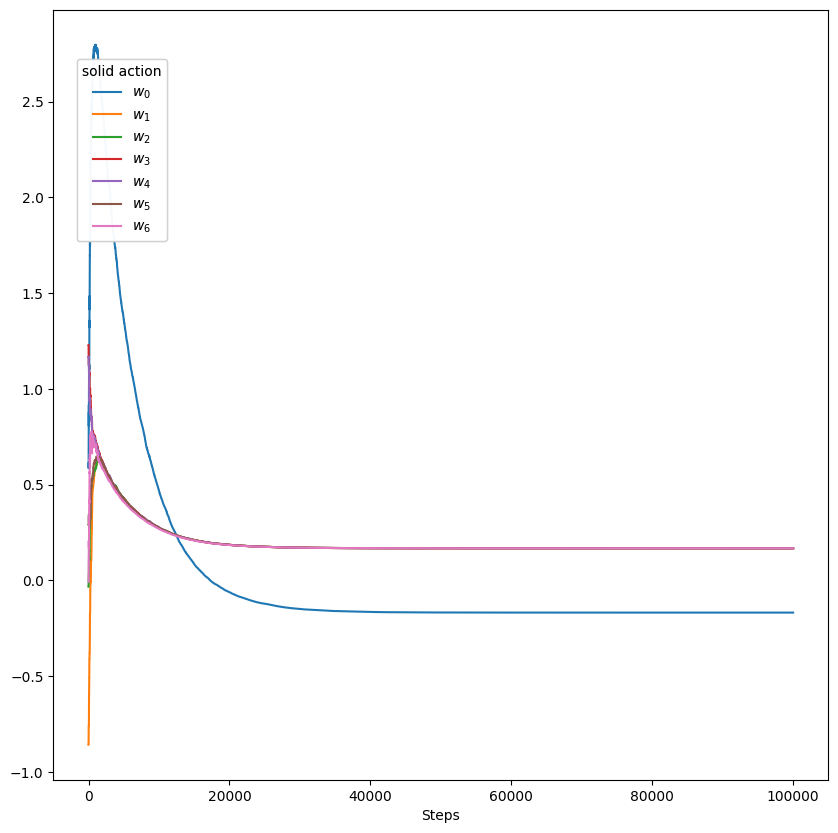

In [18]:
matplotlib.rcParams['figure.figsize'] = [10, 10]

labels = [f"$w_{i}$" for i in range(7)]

plt.gca().set_prop_cycle(None)
solid_lines = plt.plot(history, linestyle='-', label=labels)
plt.gca().set_prop_cycle(None)

solid_legend = plt.legend(handles=solid_lines, title='solid action', loc=[0.03, 0.7])

plt.gca().add_artist(solid_legend)

plt.xlabel("Steps")

plt.show()